In [18]:
from pandas import DataFrame
from ucimlrepo import fetch_ucirepo
from typing import NamedTuple, List, Dict, Any
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from pprint import pprint
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import (
    Pipeline as ImbPipeline,
)


# Type definitions from:
# https://github.com/uci-ml-repo/ucimlrepo?tab=readme-ov-file#parameters
class UciMlData(NamedTuple):
    ids: DataFrame
    features: DataFrame
    targets: DataFrame
    original: DataFrame
    headers: List[str]


class UciMlDataset(NamedTuple):
    data: UciMlData
    metadata: Dict[str, Any]
    variables: DataFrame

In [19]:
from numpy import average
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline


def perform_cross_validation(
    pipeline: Pipeline,
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    folds: int = 5,
):
    """
    Perform cross-validation and return the mean scores for specified metrics.

    Parameters:
    - pipeline: The machine learning pipeline that includes preprocessing and a classifier.
    - X_train: Training feature set as a pandas DataFrame.
    - y_train: Training target as a pandas Series.
    - folds: Number of cross-validation folds.

    Returns:
    - A dictionary containing mean scores for accuracy, precision, recall, and F1 score.
    """
    scoring = {
        "accuracy": "accuracy",
        "precision": "precision_macro",
        "recall": "recall_macro",
        "f1": "f1_macro",
    }

    cv_results = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=folds)

    mean_scores = {
        metric: np.mean(scores)
        for metric, scores in cv_results.items()
        if "test_" in metric
    }

    return mean_scores


def run_knn(
    X: DataFrame,
    y: DataFrame,
    K: int = 5,
):
    y = y.squeeze()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    pipeline = ImbPipeline(
        [
            ("impute", SimpleImputer(strategy="mean")),
            ("scale", StandardScaler()),
            ("smote", SMOTE(random_state=42)),
            ("knn", KNeighborsClassifier(n_neighbors=K, metric="euclidean")),
        ]
    )

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    report = classification_report(y_test, y_pred)
    report_dict = classification_report(y_test, y_pred, output_dict=True)

    conf_mat = confusion_matrix(y_test, y_pred)

    return report, report_dict, conf_mat


def test_knn(X: DataFrame, y: DataFrame, K: int = 5):
    report, _, conf_mat = run_knn(X, y)
    print(report)
    print(conf_mat)


def run_knn_cross_validation(
    X: DataFrame,
    y: DataFrame,
    K: int = 5,
):
    y = y.squeeze()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    pipeline = ImbPipeline(
        [
            ("impute", SimpleImputer(strategy="mean")),
            ("scale", StandardScaler()),
            ("smote", SMOTE(random_state=42)),
            ("knn", KNeighborsClassifier(n_neighbors=K, metric="euclidean")),
        ]
    )

    results = perform_cross_validation(pipeline, X_train, y_train)
    return results


def sample_dataset(
    X: pd.DataFrame, y: pd.DataFrame, n: int
) -> tuple[pd.DataFrame, pd.DataFrame]:
    # Sample dataset for faster testing
    # choose random sample of n rows
    sample_indices = X.sample(n, random_state=42).index
    X = X.loc[sample_indices]
    y = y.loc[sample_indices]
    return X, y

In [20]:
def test_cross_validation(X: pd.DataFrame, y: pd.DataFrame):
    fold_nums = [2, 5, 10]

    results = []

    for folds in fold_nums:
        res = run_knn_cross_validation(X, y, folds)
        results.append({"folds": folds, **res})
    display(pd.DataFrame(results))

In [21]:
def distance_pow(distances):
    """
    Weights votes based on the inverse of the distance.
    """
    epsilon = 1e-6
    squared_distances = distances**4
    weights = 1.0 / (squared_distances + epsilon)
    return weights


def run_with_params(X: pd.DataFrame, y: pd.DataFrame):
    ks = range(1, 16)
    metrics = ["euclidean", "manhattan", "minkowski"]
    weights = ["uniform", "distance", "distance^4"]
    results = []

    for k in ks:
        for metric in metrics:
            for weight in weights:

                y = y.squeeze()

                pipeline = ImbPipeline(
                    [
                        ("scale", StandardScaler()),
                        ("impute", SimpleImputer(strategy="mean")),
                        ("smote", SMOTE(random_state=42)),
                        (
                            "knn",
                            KNeighborsClassifier(
                                n_neighbors=k,
                                metric=metric,
                                weights=(
                                    weight if weight != "distance^4" else distance_pow
                                ),
                            ),
                        ),
                    ]
                )

                result = perform_cross_validation(pipeline, X, y)
                f1 = result["test_f1"]

                results.append({"k": k, "metric": metric, "weight": weight, "f1": f1})

    results = pd.DataFrame(results)
    results.set_index(["k", "metric", "weight"], inplace=True)

    return results


def plot_param_results(results: pd.DataFrame):

    # Reset index for easier plotting
    df_plot = results.reset_index()

    # Create line plots
    for metric in df_plot["metric"].unique():
        plt.figure(figsize=(12, 8))
        for weight in df_plot["weight"].unique():
            subset = df_plot[
                (df_plot["metric"] == metric) & (df_plot["weight"] == weight)
            ]
            plt.plot(subset["k"], subset["f1"], label=f"{metric} - {weight}")

        plt.xlabel("Number of Neighbors k")
        plt.ylabel("F1 Score")
        plt.title(f"F1 Score by Number of Neighbors k and Weights (Metric: {metric})")
        plt.legend(title="Metrics/Weights", loc="best")
        plt.grid(True)
        plt.show()


def test_params(X: pd.DataFrame, y: pd.DataFrame, min: int = 1, max: int = 16):
    results = run_with_params(X, y)
    display(results)
    plot_param_results(results)

    print("Best combination")
    best_combination = results["f1"].idxmax()
    print(best_combination)

# IRIS

In [22]:
iris: UciMlDataset = fetch_ucirepo(id=53)

In [23]:
X_iris = iris.data.features
y_iris = iris.data.targets

display(X_iris.head())
display(y_iris.head())

,sepal length,sepal width,petal length,petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


,class
0,Iris-setosa
1,Iris-setosa
2,Iris-setosa
3,Iris-setosa
4,Iris-setosa


## 3. k-NN algorithm without crossvalidation

In [24]:
test_knn(X_iris, y_iris)

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      1.00      1.00         9
 Iris-virginica       1.00      1.00      1.00        11

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30

[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]


## 4. k-NN algorithm with crossvalidation

In [25]:
test_cross_validation(X_iris, y_iris)

,folds,test_accuracy,test_precision,test_recall,test_f1
0,2,0.933333,0.942328,0.932143,0.932403
1,5,0.933333,0.941481,0.932143,0.932203
2,10,0.941667,0.948254,0.940476,0.940968


### Crossvalidation results for IRIS dataset

With crossvalidation f1 scores where worse than without crossvalidation.

#### Fold sizes comparison

The best result (f1 score) was obtained with 10 folds. 


## 5. Parameters tests

f1
k  metric    weight              
1  euclidean uniform     0.946465
             distance    0.946465
             distance^4  0.946465
   manhattan uniform     0.939782
             distance    0.939782
...                           ...
15 manhattan distance    0.952840
             distance^4  0.946123
   minkowski uniform     0.939883
             distance    0.959832
             distance^4  0.953115

[135 rows x 1 columns]

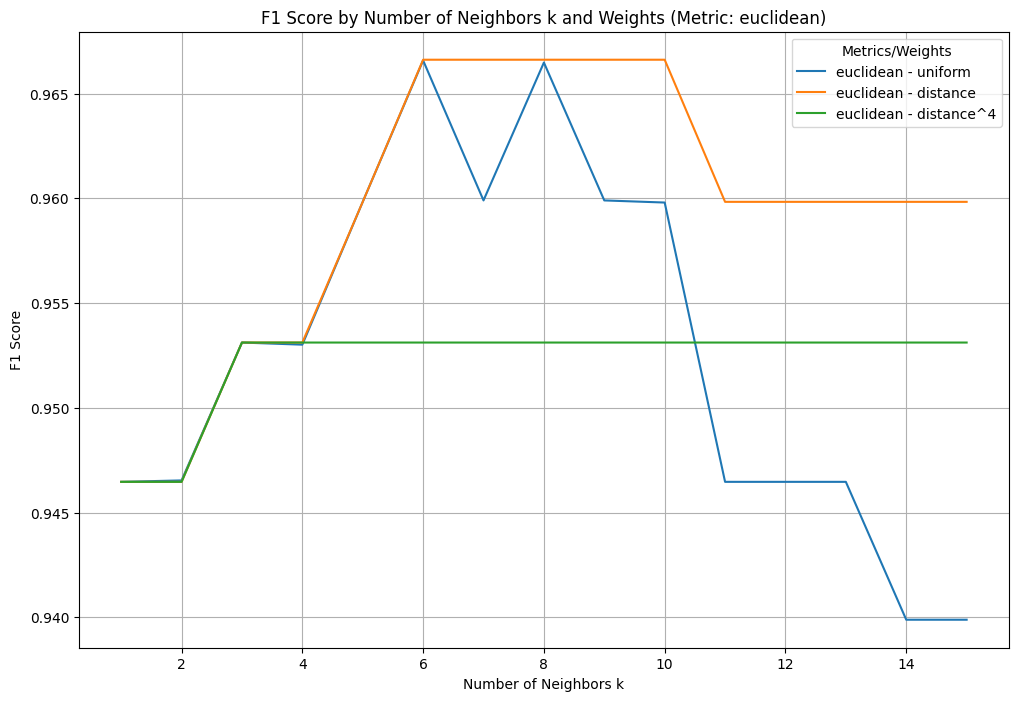

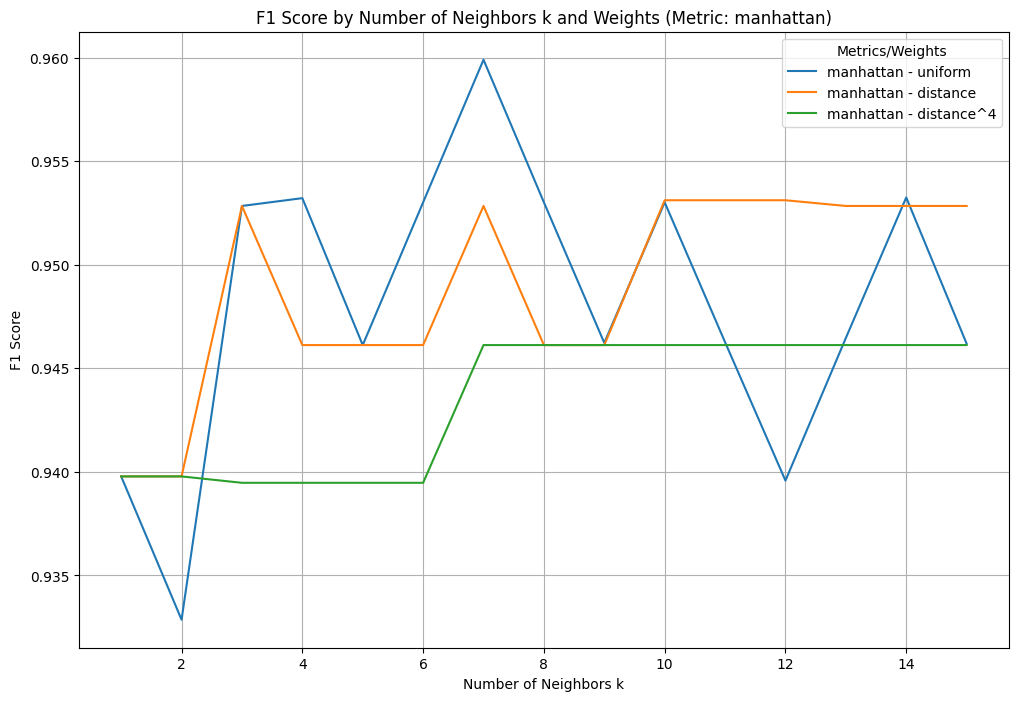

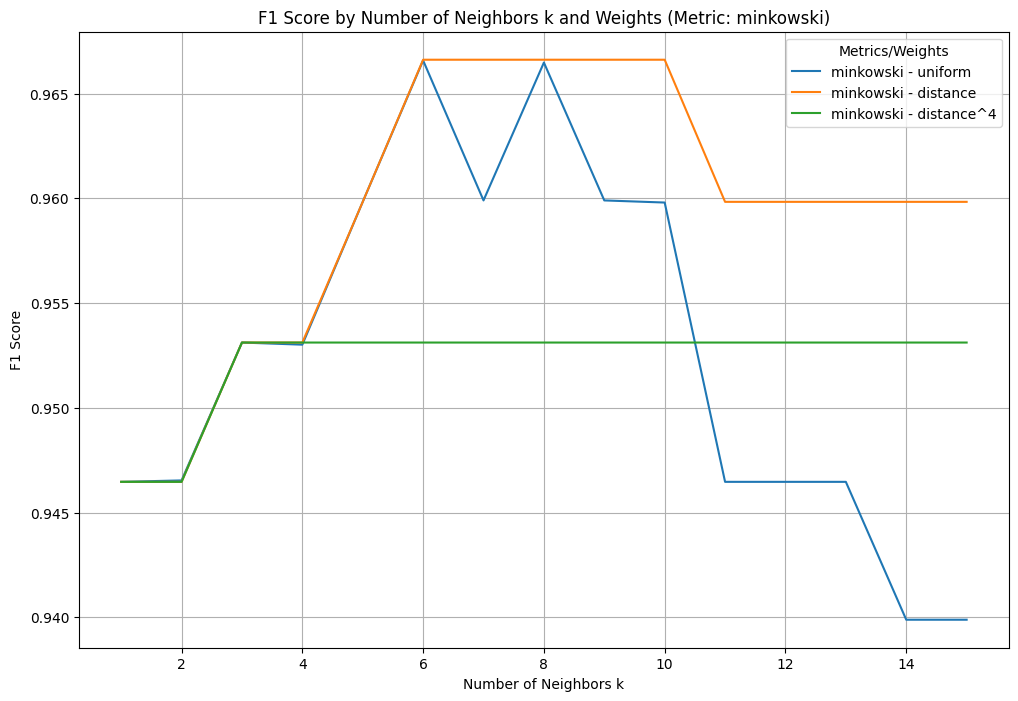

Best combination
(6, 'euclidean', 'distance')


In [26]:
test_params(X_iris, y_iris)

# WINE

In [27]:
wine: UciMlDataset = fetch_ucirepo(id=109)

In [28]:
X_wine = wine.data.features
y_wine = wine.data.targets

## kNN without cross validation

In [29]:
test_knn(X_wine, y_wine)

              precision    recall  f1-score   support

           1       0.93      1.00      0.97        14
           2       1.00      0.86      0.92        14
           3       0.89      1.00      0.94         8

    accuracy                           0.94        36
   macro avg       0.94      0.95      0.94        36
weighted avg       0.95      0.94      0.94        36

[[14  0  0]
 [ 1 12  1]
 [ 0  0  8]]


## k-NN with cross validation

In [30]:
test_cross_validation(X_wine, y_wine)

,folds,test_accuracy,test_precision,test_recall,test_f1
0,2,0.936700,0.943064,0.947475,0.940019
1,5,0.950985,0.951582,0.959596,0.951875
2,10,0.929803,0.932795,0.941919,0.931870


### Cross validation results for WINE dataset

With cross validation the results were better than without cross validation.
The best result was obtained with 5-fold cross validation.

f1
k  metric    weight              
1  euclidean uniform     0.944615
             distance    0.944615
             distance^4  0.944615
   manhattan uniform     0.961228
             distance    0.961228
...                           ...
15 manhattan distance    0.950737
             distance^4  0.949901
   minkowski uniform     0.938575
             distance    0.938575
             distance^4  0.938598

[135 rows x 1 columns]

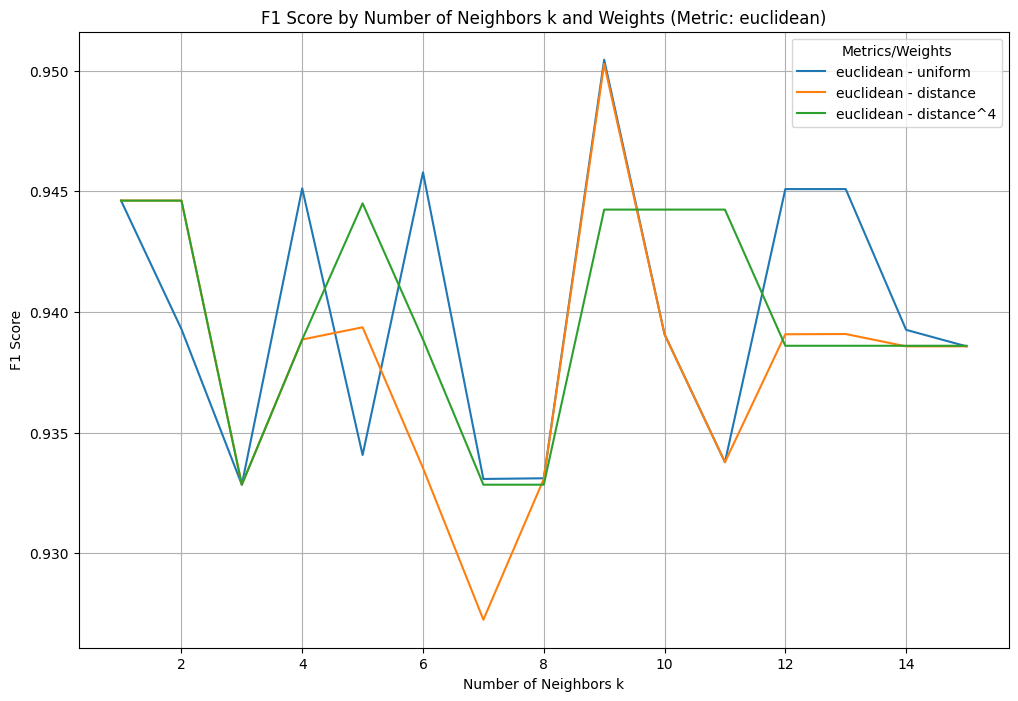

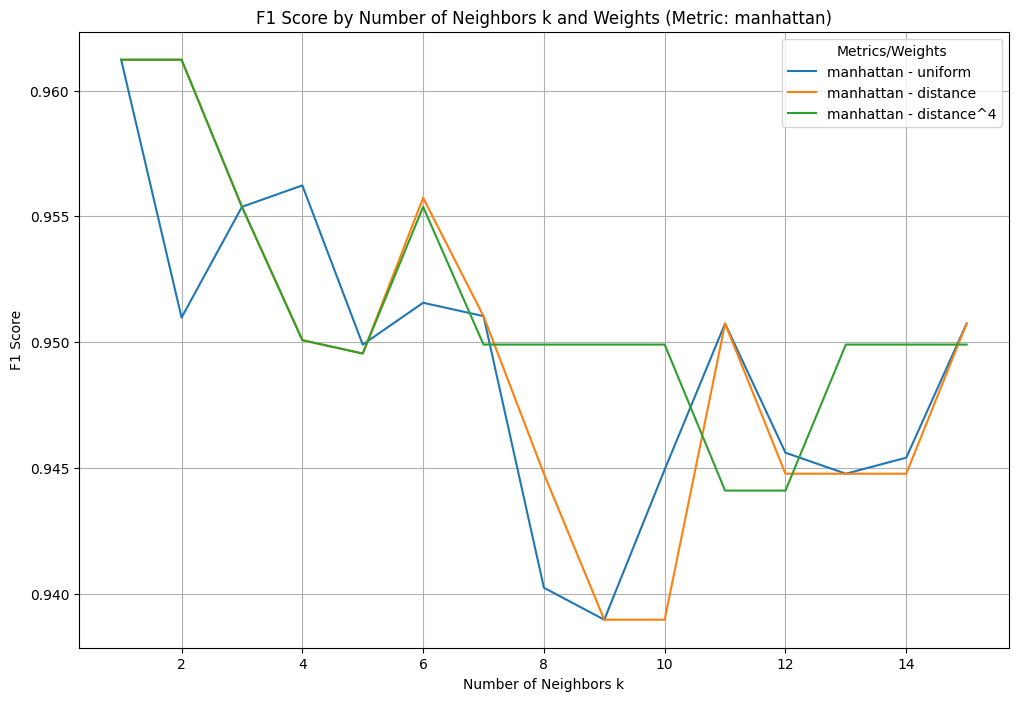

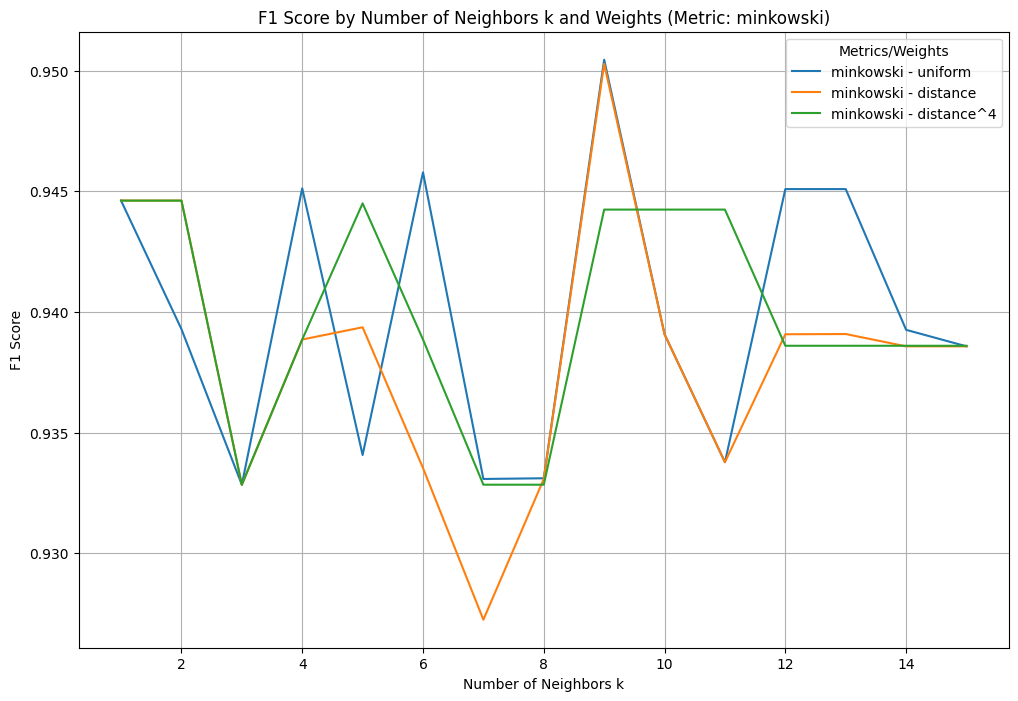

Best combination
(1, 'manhattan', 'uniform')


In [31]:
test_params(X_wine, y_wine)

# Polish Companies Bankruptcy Data (PCB)

In [32]:
pcb: UciMlDataset = fetch_ucirepo(id=365)

X_pcb = pcb.data.features
y_pcb = pcb.data.targets

In [33]:
# drop column A37 (based on previous analysis)
print("Drop column A37")
X_pcb = X_pcb.drop(columns=["A37"])

Drop column A37


## k-NN without cross validation

In [34]:
test_knn(X_pcb, y_pcb)

              precision    recall  f1-score   support

           0       0.96      0.81      0.88      8240
           1       0.10      0.41      0.16       441

    accuracy                           0.79      8681
   macro avg       0.53      0.61      0.52      8681
weighted avg       0.92      0.79      0.84      8681

[[6650 1590]
 [ 261  180]]


## Cross validation

In [35]:
test_cross_validation(X_pcb, y_pcb)

,folds,test_accuracy,test_precision,test_recall,test_f1
0,2,0.873949,0.529059,0.556952,0.533350
1,5,0.785883,0.528296,0.601703,0.513839
2,10,0.766617,0.529535,0.614910,0.509375


### cross validation results for PCB dataset

The best result was obtain with 2-fold cross validation.

# Testing k-NN algorithm with different parameters

In [36]:
print(X_pcb.shape)

(43405, 64)


f1
k  metric    weight              
1  euclidean uniform     0.515968
             distance    0.515968
             distance^4  0.515968
   manhattan uniform     0.533168
             distance    0.533168
...                           ...
15 manhattan distance    0.487409
             distance^4  0.507219
   minkowski uniform     0.474175
             distance    0.479698
             distance^4  0.488983

[135 rows x 1 columns]

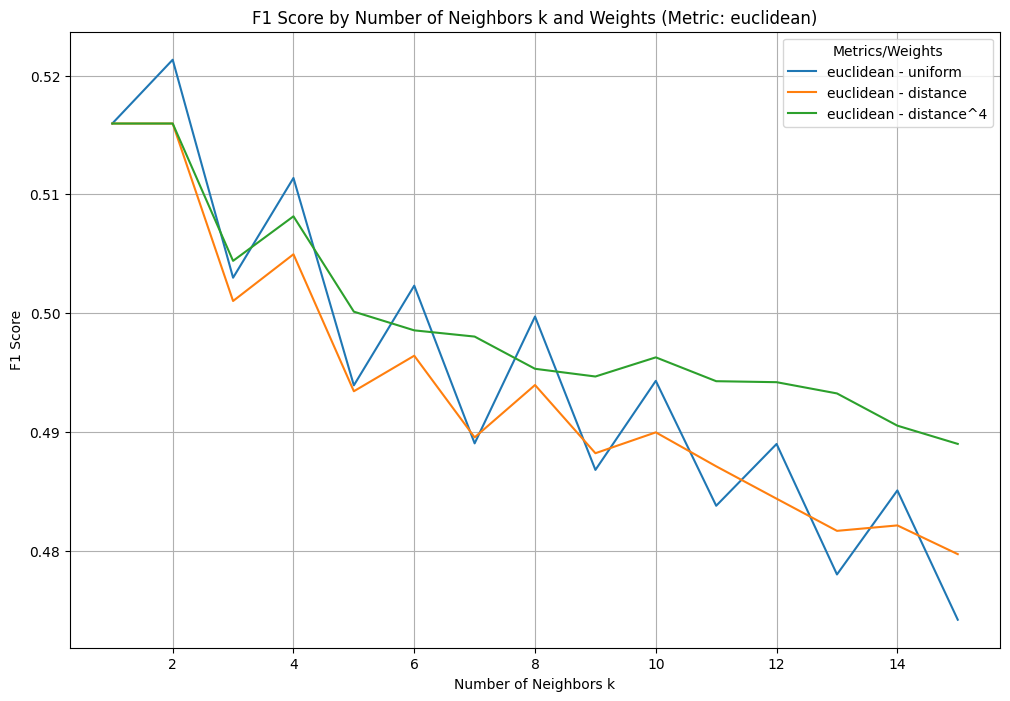

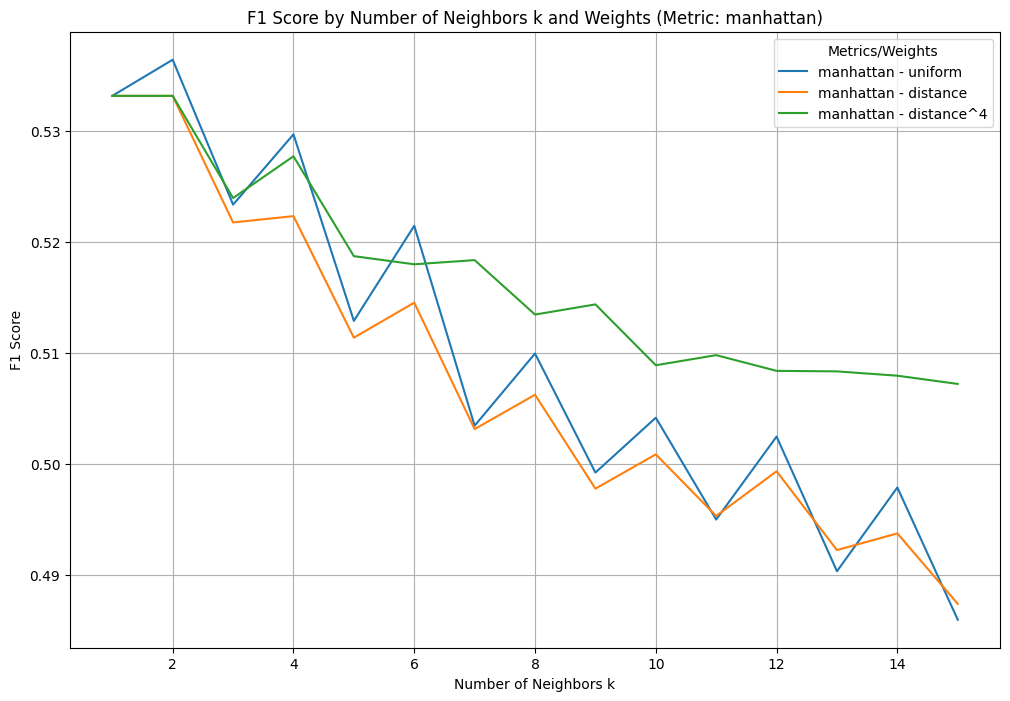

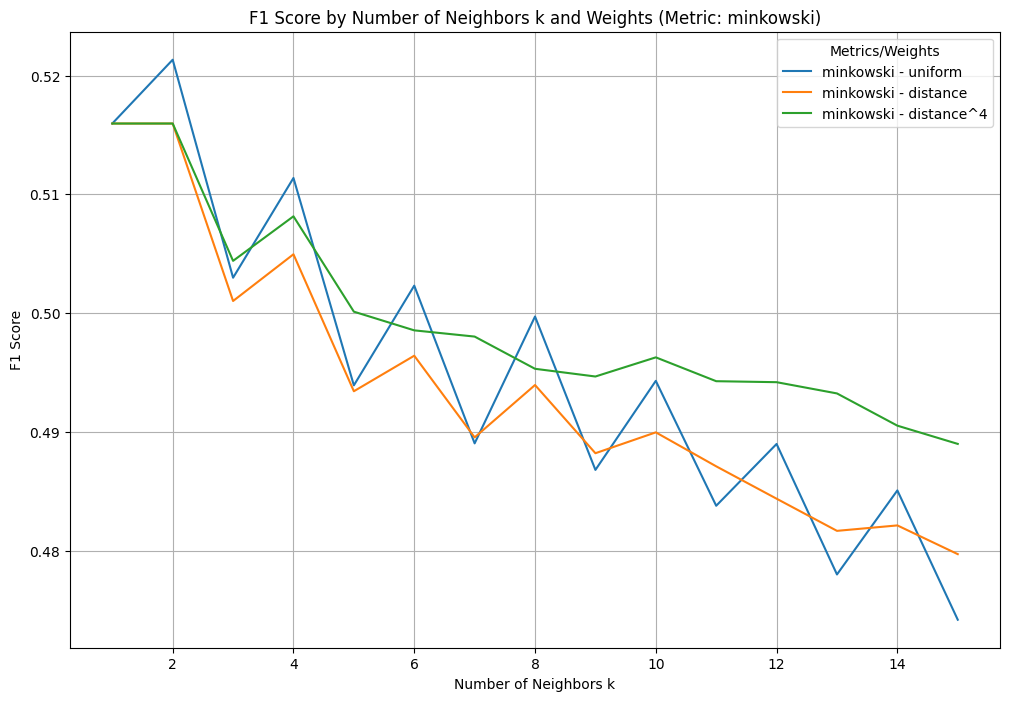

Best combination
(2, 'manhattan', 'uniform')


In [37]:
X_pcb_sample, y_pcb_sample = sample_dataset(X_pcb, y_pcb, 5000)

test_params(X_pcb_sample, y_pcb_sample, 1, 10)